In [59]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import silhouette_score
import plotly.express as px


In [60]:
mls25_def = pd.read_csv('/Users/amitmishra/fbref-analytics/data/mls2025_defense_cleaned.csv')
mls25_shots = pd.read_csv('/Users/amitmishra/fbref-analytics/data/mls2025_shooting_cleaned.csv')
mls25_gca = pd.read_csv('/Users/amitmishra/fbref-analytics/data/mls2025_gca_cleaned.csv')
mls25_std = pd.read_csv('/Users/amitmishra/fbref-analytics/data/mls2025_standard_cleaned.csv')
mls25_poss = pd.read_csv('/Users/amitmishra/fbref-analytics/data/mls2025_possession_cleaned.csv')
mls25_pass = pd.read_csv('/Users/amitmishra/fbref-analytics/data/mls2025_passing_cleaned.csv')

In [61]:
mls25_pass.columns

Index(['Squad', 'Players_used', '90s', 'Pass_Cmp', 'Pass_Att', 'Pass_Cmp%',
       'Pass_TotDist', 'Pass_PrgDist', 'ShortPass_Cmp', 'ShortPass_Att',
       'ShortPass_Cmp%', 'MedPass_Cmp', 'MedPass_Att', 'MedPass_Cmp%',
       'LongPass_Cmp', 'LongPass_Att', 'LongPass_Cmp%', 'Assists', 'xAG', 'xA',
       'A-xAG', 'KeyPasses', 'Pass_FinalTrd', 'Pass_PenArea', 'Crs_PenArea',
       'PrgP'],
      dtype='object')

In [62]:
pass_stats = ['Squad', 'Pass_Cmp%','Pass_PenArea','KeyPasses']
gca_stats = ['Squad', 'GCA_PassLive','SCA_Passlive']
poss_stats = ['Squad','Touches_AttPen']
shots_stats = ['Squad', 'Sh/90','npxG','Shot_Dist','G/Sh']


In [63]:
df = mls25_pass[pass_stats]

In [64]:
merged_df = df.merge(mls25_shots[shots_stats], on = 'Squad', how = 'left')

In [65]:
merged_df = merged_df.merge(mls25_gca[gca_stats], on = 'Squad', how = 'left')

In [66]:
merged_df = merged_df.merge(mls25_poss[poss_stats], on = 'Squad', how = 'left')

In [67]:
merged_df.head()

,Squad,Pass_Cmp%,Pass_PenArea,KeyPasses,Sh/90,npxG,Shot_Dist,G/Sh,GCA_PassLive,SCA_Passlive,Touches_AttPen
0,Atlanta Utd,82.0,81,95,13.00,12.1,16.0,0.07,12,163,239
1,Austin,81.2,61,85,12.33,11.2,18.6,0.06,7,155,178
2,CF Montréal,80.8,75,67,10.56,9.8,16.9,0.04,3,127,172
3,Charlotte,82.5,60,68,10.22,11.1,15.9,0.14,10,119,176
4,Chicago Fire,82.8,57,81,12.00,13.6,17.1,0.13,17,149,173


In [68]:
# Perform aggregation by club, calculating means for numerical columns
agg_df = merged_df.groupby('Squad').mean()

In [69]:
#handle missing values by using imputer
imputer = SimpleImputer(strategy = 'mean')
imputed_df = imputer.fit_transform(agg_df)

In [70]:
agg_df.isna().sum()

Pass_Cmp%         0
Pass_PenArea      0
KeyPasses         0
Sh/90             0
npxG              0
Shot_Dist         0
G/Sh              0
GCA_PassLive      0
SCA_Passlive      0
Touches_AttPen    0
dtype: int64

In [71]:
#Standardize the data

scaler = StandardScaler()
scaled_df = scaler.fit_transform(agg_df)

In [72]:
scaled_df = pd.DataFrame(scaled_df)
scaled_df.head()

,0,1,2,3,4,5,6,7,8,9
0,0.288262,0.557552,0.921047,0.397712,0.221524,-1.139126,-0.860477,-0.326376,0.681102,1.155339
1,0.067934,-0.734074,0.245463,0.092713,-0.096622,1.001882,-1.187240,-1.185259,0.377265,-0.570596
2,-0.042229,0.170064,-0.970590,-0.713028,-0.591516,-0.398008,-1.840766,-1.872366,-0.686166,-0.740360
3,0.425967,-0.798655,-0.903032,-0.867804,-0.131972,-1.221472,1.426866,-0.669929,-0.990004,-0.627184
4,0.508590,-0.992399,-0.024771,-0.057510,0.751767,-0.233315,1.100103,0.532508,0.149387,-0.712066


### Apply KMeans clustering

In [73]:
num_clusters = 3
kmeans = KMeans(n_clusters = num_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(scaled_df)

In [74]:
#add the cluster labels back to the aggregated dataframe
agg_df['cluster'] = cluster_labels

In [75]:
agg_df.head()

,Pass_Cmp%,Pass_PenArea,KeyPasses,Sh/90,npxG,Shot_Dist,G/Sh,GCA_PassLive,SCA_Passlive,Touches_AttPen,cluster
Squad,,,,,,,,,,,
Atlanta Utd,82.0,81.0,95.0,13.00,12.1,16.0,0.07,12.0,163.0,239.0,1
Austin,81.2,61.0,85.0,12.33,11.2,18.6,0.06,7.0,155.0,178.0,2
CF Montréal,80.8,75.0,67.0,10.56,9.8,16.9,0.04,3.0,127.0,172.0,2
Charlotte,82.5,60.0,68.0,10.22,11.1,15.9,0.14,10.0,119.0,176.0,0
Chicago Fire,82.8,57.0,81.0,12.00,13.6,17.1,0.13,17.0,149.0,173.0,0


In [76]:
#Finding optimum clusters

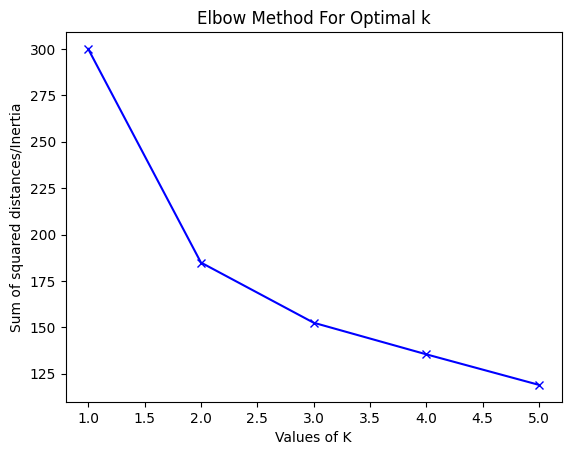

In [77]:
sum_sd = []
k = range(1,6)
for num_clusters in k:
    kmeans = KMeans(n_clusters = num_clusters, random_state=42)
    kmeans.fit(scaled_df)
    sum_sd.append(kmeans.inertia_)
plt.plot(k,sum_sd,"bx-")
plt.xlabel("Values of K") 
plt.ylabel("Sum of squared distances/Inertia") 
plt.title("Elbow Method For Optimal k")
plt.show()

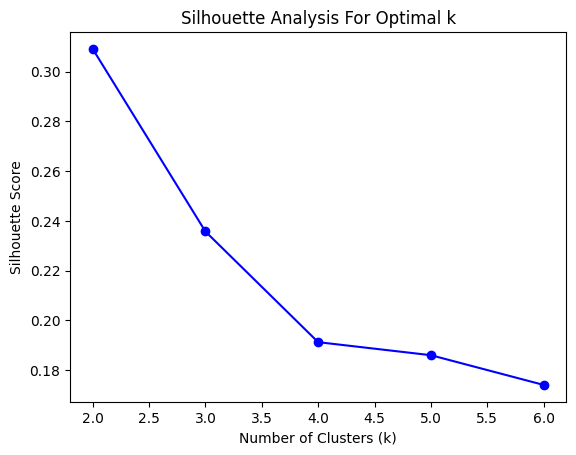

In [78]:
silhouette_scores = []
for k in range(2, 7):  # Silhouette score isn't defined for k=1
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(scaled_df)
    silhouette_scores.append(silhouette_score(scaled_df, cluster_labels))
    
plt.plot(range(2, 7), silhouette_scores, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis For Optimal k')
plt.show()

## K = 2: This might represent a fundamental division like possession-oriented vs. counter-attacking teams, or offensive vs. defensive-minded approaches.

## K = 3: Also performs relatively well, indicating there might be four meaningful tactical archetypes among MLS teams.

In [79]:
agg_df[agg_df['cluster'] == 0]

,Pass_Cmp%,Pass_PenArea,KeyPasses,Sh/90,npxG,Shot_Dist,G/Sh,GCA_PassLive,SCA_Passlive,Touches_AttPen,cluster
Squad,,,,,,,,,,,
Charlotte,82.5,60.0,68.0,10.22,11.1,15.9,0.14,10.0,119.0,176.0,0
Chicago Fire,82.8,57.0,81.0,12.00,13.6,17.1,0.13,17.0,149.0,173.0,0
Colorado Rapids,75.6,79.0,74.0,11.00,11.6,17.3,0.10,20.0,136.0,215.0,0
FC Dallas,79.4,72.0,69.0,9.56,10.2,16.8,0.12,11.0,123.0,207.0,0
Inter Miami,84.9,78.0,70.0,10.87,13.2,16.9,0.15,19.0,118.0,160.0,0
LAFC,83.8,64.0,75.0,11.44,11.0,17.9,0.12,11.0,130.0,194.0,0
Portland Timbers,82.3,41.0,70.0,10.33,9.9,17.3,0.14,14.0,125.0,157.0,0
Sporting KC,80.2,79.0,67.0,9.56,8.0,17.4,0.14,19.0,116.0,215.0,0
Toronto FC,79.1,44.0,47.0,7.33,5.8,18.8,0.11,10.0,94.0,119.0,0


In [80]:
agg_df[agg_df['cluster'] == 1]

,Pass_Cmp%,Pass_PenArea,KeyPasses,Sh/90,npxG,Shot_Dist,G/Sh,GCA_PassLive,SCA_Passlive,Touches_AttPen,cluster
Squad,,,,,,,,,,,
Atlanta Utd,82.0,81.0,95.0,13.00,12.1,16.0,0.07,12.0,163.0,239.0,1
Columbus Crew,86.6,100.0,88.0,12.56,13.6,17.3,0.10,17.0,150.0,236.0,1
D.C. United,76.7,90.0,88.0,12.56,11.5,15.7,0.09,14.0,147.0,221.0,1
Minnesota Utd,70.3,64.0,87.0,13.44,14.7,15.5,0.08,13.0,152.0,240.0,1
Nashville SC,81.1,75.0,97.0,14.56,11.2,17.0,0.08,15.0,168.0,203.0,1
Orlando City,80.6,76.0,102.0,13.78,13.5,16.3,0.11,20.0,174.0,197.0,1
Philadelphia Union,73.9,78.0,98.0,15.22,14.7,18.0,0.12,23.0,184.0,219.0,1
SJ Earthquakes,77.6,82.0,110.0,17.33,18.4,17.6,0.10,26.0,216.0,235.0,1
San Diego FC,86.5,101.0,91.0,13.11,14.4,16.6,0.13,20.0,163.0,228.0,1


In [81]:
agg_df[agg_df['cluster'] == 2]

,Pass_Cmp%,Pass_PenArea,KeyPasses,Sh/90,npxG,Shot_Dist,G/Sh,GCA_PassLive,SCA_Passlive,Touches_AttPen,cluster
Squad,,,,,,,,,,,
Austin,81.2,61.0,85.0,12.33,11.2,18.6,0.06,7.0,155.0,178.0,2
CF Montréal,80.8,75.0,67.0,10.56,9.8,16.9,0.04,3.0,127.0,172.0,2
FC Cincinnati,80.9,63.0,89.0,13.00,10.3,19.8,0.09,14.0,159.0,195.0,2
Houston Dynamo,83.9,71.0,69.0,9.89,8.2,16.8,0.09,8.0,118.0,191.0,2
LA Galaxy,86.0,62.0,76.0,10.67,7.3,18.9,0.06,10.0,143.0,156.0,2
NE Revolution,79.2,59.0,63.0,10.13,5.9,19.3,0.04,6.0,109.0,170.0,2
NY Red Bulls,81.5,65.0,71.0,10.56,10.4,18.3,0.07,14.0,126.0,171.0,2
NYCFC,80.7,75.0,79.0,12.22,10.7,18.4,0.09,6.0,142.0,210.0,2
Real Salt Lake,82.6,52.0,80.0,13.78,11.4,20.0,0.06,10.0,157.0,152.0,2


In [82]:
agg_df['cluster'] = agg_df['cluster'].replace([0,1,2], ['Balanced', 'Aggressive Penetrators', 'Conservative'])

In [83]:
agg_df.columns

Index(['Pass_Cmp%', 'Pass_PenArea', 'KeyPasses', 'Sh/90', 'npxG', 'Shot_Dist',
       'G/Sh', 'GCA_PassLive', 'SCA_Passlive', 'Touches_AttPen', 'cluster'],
      dtype='object')

In [84]:
features = ['Pass_Cmp%', 'Pass_PenArea', 'KeyPasses', 'Sh/90', 'npxG', 'Shot_Dist',
       'G/Sh', 'GCA_PassLive', 'SCA_Passlive', 'Touches_AttPen']

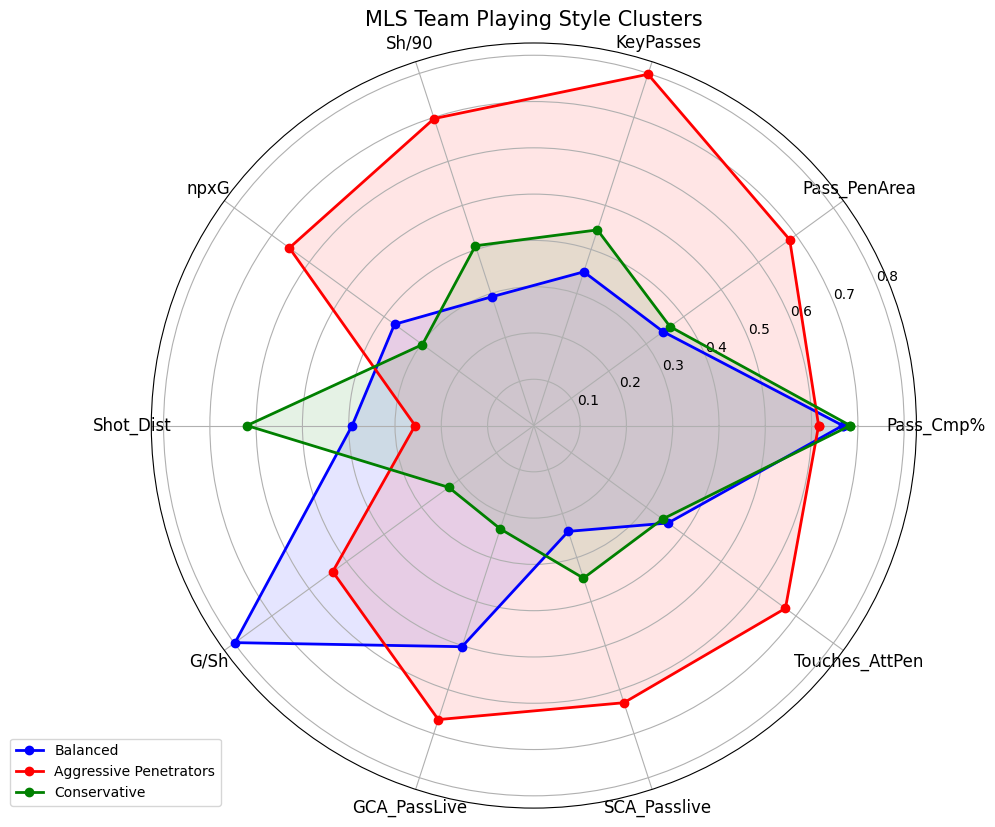

In [85]:
import numpy as np
import matplotlib.pyplot as plt

# Define your cluster labels
cluster_labels = ['Balanced', 'Aggressive Penetrators', 'Conservative']

# Calculate cluster centroids
centroids = []
for label in cluster_labels:
    centroids.append(agg_df[agg_df['cluster'] == label][features].mean())

# Set up radar chart
def radar_chart(fig, variables, ranges, cluster_labels):
    # Calculate angles for each variable
    angles = np.linspace(0, 2*np.pi, len(variables), endpoint=False).tolist()
    angles += angles[:1]  # Close the loop
    
    # Set up the subplot
    ax = fig.add_subplot(111, polar=True)
    
    # Add variable labels
    plt.xticks(angles[:-1], variables, size=12)
    
    # Draw the cluster profiles
    colors = ['blue', 'red', 'green']
    for i, label in enumerate(cluster_labels):
        values = centroids[i].values.flatten().tolist()
        # Scale values between 0 and 1 for better visualization
        scaled_values = [(val - ranges[j][0]) / (ranges[j][1] - ranges[j][0]) 
                        for j, val in enumerate(values)]
        scaled_values += scaled_values[:1]  # Close the loop
        
        ax.plot(angles, scaled_values, 'o-', linewidth=2, label=label, color=colors[i])
        ax.fill(angles, scaled_values, alpha=0.1, color=colors[i])
    
    # Add legend
    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
    
    return ax

# Get min and max for each feature for scaling
ranges = [(agg_df[feature].min(), agg_df[feature].max()) for feature in features]

# Create the figure and plot
fig = plt.figure(figsize=(10, 10))
radar_chart(fig, features, ranges, cluster_labels)
plt.title('MLS Team Playing Style Clusters', size=15)
plt.tight_layout()

In [86]:
# Print mean values for each cluster
for cluster in ['Balanced', 'Aggressive Penetrators', 'Conservative']:
    print(f"\n{cluster} Cluster Mean Values:")
    print(agg_df[agg_df['cluster'] == cluster][features].mean().round(1))


Balanced Cluster Mean Values:
Pass_Cmp%          81.2
Pass_PenArea       63.8
KeyPasses          69.0
Sh/90              10.3
npxG               10.5
Shot_Dist          17.3
G/Sh                0.1
GCA_PassLive       14.6
SCA_Passlive      123.3
Touches_AttPen    179.6
dtype: float64

Aggressive Penetrators Cluster Mean Values:
Pass_Cmp%          80.3
Pass_PenArea       86.1
KeyPasses          97.3
Sh/90              14.3
npxG               14.0
Shot_Dist          16.7
G/Sh                0.1
GCA_PassLive       18.4
SCA_Passlive      170.8
Touches_AttPen    232.5
dtype: float64

Conservative Cluster Mean Values:
Pass_Cmp%          81.4
Pass_PenArea       65.0
KeyPasses          75.0
Sh/90              11.4
npxG                9.6
Shot_Dist          18.3
G/Sh                0.1
GCA_PassLive        8.4
SCA_Passlive      136.3
Touches_AttPen    177.1
dtype: float64


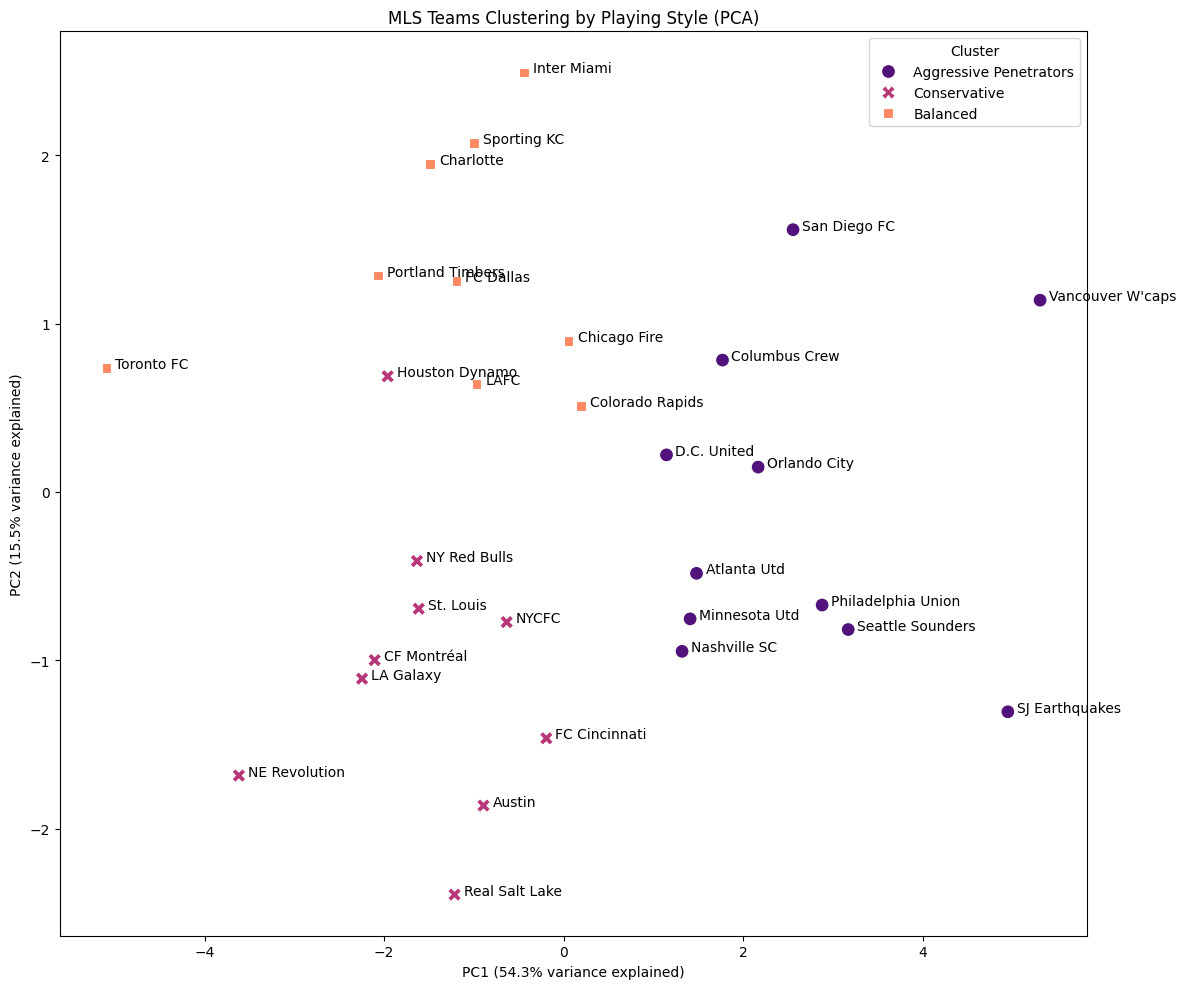

In [87]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Standardize data for PCA
X = agg_df[features].values
X_scaled = StandardScaler().fit_transform(X)

# Apply PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Create a DataFrame for plotting
plot_df = pd.DataFrame({
    'PC1': X_pca[:, 0],
    'PC2': X_pca[:, 1],
    'Cluster': agg_df['cluster'],
    'Squad': agg_df.index if 'Squad' not in agg_df.columns else agg_df['Squad']
})

# Create scatter plot
plt.figure(figsize=(12, 10))
sns.scatterplot(data=plot_df, x='PC1', y='PC2', hue='Cluster', 
                palette='magma', s=100, style='Cluster')

# Annotate team names
for idx, row in plot_df.iterrows():
    plt.annotate(row['Squad'], 
                 (row['PC1'] + 0.1, row['PC2']), 
                 fontsize=10)

# Add explained variance
explained_var = pca.explained_variance_ratio_ * 100
plt.xlabel(f'PC1 ({explained_var[0]:.1f}% variance explained)')
plt.ylabel(f'PC2 ({explained_var[1]:.1f}% variance explained)')
plt.title('MLS Teams Clustering by Playing Style (PCA)')
plt.tight_layout()